## Using Deep Learning on Kings County Housing Data
---

In [1]:
#set print and reload settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
%reload_ext autoreload
%autoreload 2
np.set_printoptions(threshold=50,edgeitems=20)
sns.set_palette("GnBu_d")
from scipy import stats
from scipy.stats import norm,skew

In [2]:
# import fast ai libraries
from fastai.structured import *
from fastai.column_data import *
import torch

In [3]:
# read data
orig_df = pd.read_csv('kc_house_data.csv', parse_dates=['date'],index_col=['id'])
print("No of columns: {}".format(len(orig_df.columns)))
print("No of rows: {}".format(len(orig_df)))
print(orig_df.columns)

No of columns: 20
No of rows: 21613
Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
#view missing data
orig_df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

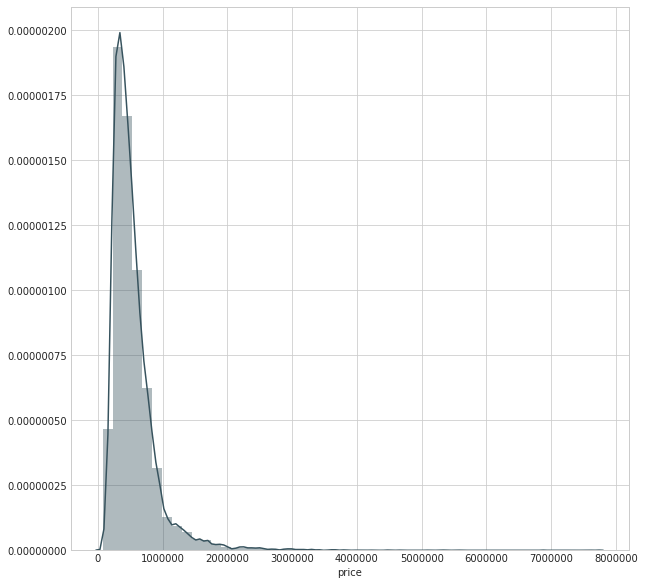

In [5]:
# view distribution of data
plt.figure(figsize=(10,10))
sns.distplot(orig_df.price,bins=50,norm_hist=True)
plt.show()

In [6]:
def process_df(df):
    # add feature engineering
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df.drop('date',inplace=True,axis=1)
    df['age'] = df['year'] - df['yr_built']
    df['is_renovated'] = (df['yr_renovated'] !=0).astype(int)
    df['last_renovated']= 0
    df['last_renovated'][df['is_renovated']==1] = df['year'] - df['yr_renovated']     
    df.drop('zipcode',inplace=True,axis=1)
    df.drop('lat',inplace=True,axis=1)
    df.drop('long',inplace=True,axis=1)
    df.price = df.price.astype('float32')
    return df

df = process_df(orig_df)
df.columns

/home/hyperion/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'year', 'month', 'age', 'is_renovated', 'last_renovated'],
      dtype='object')

In [8]:
# Convert datatypes 

# Define categorical data
cat_vars = ['floors', 'waterfront', 'view', 'condition', 'grade','year','month','is_renovated']
# Continuous Data
cont_vars = ['sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','sqft_basement','yr_built','last_renovated',
            'age','bedrooms', 'bathrooms']
# Dependent variable
target = ['price']

# Torch requires continuous variables to be float 32 type
for feat in cont_vars:
    df[feat] = df[feat].astype('float32')
# Convert categorical variables to category datatype
for feat in cat_vars: 
    df[feat] = df[feat].astype('category').cat.as_ordered()

In [9]:
# fast ai scales continuous variables
df, y, nas, mapper = proc_df(df, 'price', do_scale=True)
# Convert price to log price
yl = np.log(y)

In [10]:
# create training set
n=len(df)
train_ratio = 0.8
train_size = int(n*train_ratio);train_size
val_idx = list(range(train_size,len(df)))

In [11]:
# How many unique categories are there?
cat_sz = [(c,len(df[c].unique())+1) for c in cat_vars]
cat_sz

[('floors', 7),
 ('waterfront', 3),
 ('view', 6),
 ('condition', 6),
 ('grade', 13),
 ('year', 3),
 ('month', 13),
 ('is_renovated', 3)]

In [12]:
# Take cardinality, divide by 2 but not more than 50
emb_szs = [(c,min(50,(c+1)//2)) for _,c in cat_sz]
emb_szs

[(7, 4), (3, 2), (6, 3), (6, 3), (13, 7), (3, 2), (13, 7), (3, 2)]

In [15]:
# y variable is float32

PATH='/home/hyperion/fastai/courses/dl1/data/housing/'

md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), 
                                       cat_flds=cat_vars, bs=128,test_df=None)

In [17]:
# define metrics and pred range
max_yl = np.max(yl)
y_range = (0, max_yl *1.2)

# use mse
from sklearn.metrics import mean_squared_error
def rmse(y_pred,targ):
    return np.sqrt(mean_squared_error(targ,y_pred))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.088979   0.456888  



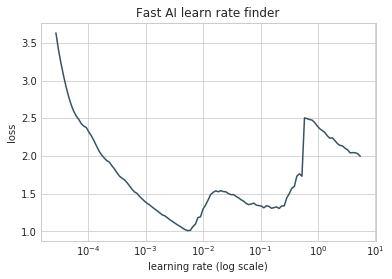

In [18]:
# create a learner to get learning rate
mlearn = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), # how many continuous variables
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
mlearn.lr_find()
plt.title("Fast AI learn rate finder")
mlearn.sched.plot()
plt.show()

In [19]:
# Create Learner Object
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), # how many continuous variables
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4

# train model cycle len 1
# cycle_len=1 means continue to decrease lr of course of 1 epoch
# cycle_mult parameter says to multiply the length of a cycle by something (in this case, 2) 
m.fit(lr, 10, metrics=[rmse], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   rmse                         
    0      0.765184   0.395464   0.627782  
    1      0.341011   0.222423   0.470626                     
    2      0.261395   0.17773    0.421102                     
    3      0.220472   0.159967   0.39951                      
    4      0.198247   0.145253   0.380631                     
    5      0.201114   0.142644   0.377076                     
    6      0.187564   0.140241   0.37395                     
    7      0.180982   0.129007   0.358696                     
    8      0.166259   0.125566   0.353878                     
    9      0.163524   0.125174   0.353256                     



[0.12517428, 0.35325566]

In [20]:
# train again with cycle len = 2
lr = 1e-4
m.fit(lr, 30, metrics=[rmse], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=60), HTML(value='')))

epoch      trn_loss   val_loss   rmse                         
    0      0.177467   0.146196   0.381936  
    1      0.144721   0.114629   0.337861                     
    2      0.175074   0.128669   0.357742                     
    3      0.136378   0.113002   0.335391                     
    4      0.142616   0.125318   0.353597                     
    5      0.130688   0.108841   0.329127                     
    6      0.151511   0.131318   0.360768                     
    7      0.121058   0.110947   0.332492                     
    8      0.146028   0.120341   0.345588                     
    9      0.113777   0.107706   0.327461                     
    10     0.130638   0.126173   0.35464                      
    11     0.112245   0.103612   0.321071                     
    12     0.126691   0.10735    0.326874                     
    13     0.106845   0.102514   0.319449                     
    14     0.116243   0.102144   0.318756                     
    15     

[0.09166514, 0.30199248]

In [21]:
# run on test set
x,y=m.predict_with_targs()
rmse(x,y)

0.3029637

## Using Traditional ML techniques
---

In [22]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [23]:
# Load data and split for other sklearn algoritms
orig_df = pd.read_csv('kc_house_data.csv',parse_dates=['date'],index_col=['id'])
train = process_df(orig_df)
# Print dtypes
train.dtypes

/home/hyperion/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


price             float32
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
sqft_basement       int64
yr_built            int64
yr_renovated        int64
sqft_living15       int64
sqft_lot15          int64
year                int64
month               int64
age                 int64
is_renovated        int64
last_renovated      int64
dtype: object

In [24]:
X = train.drop('price')
y= np.log(train.price) # take log of price to make it comparable to above

In [25]:
# validation function
n_folds = 5

# define rmse function
def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv=cv))
    return(rmse)

In [26]:
# Define models but used scalers to make it robust
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.001))

ENet = make_pipeline(RobustScaler(),ElasticNet(random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Used huber linear regression to make it robust to outliers
GBoost = GradientBoostingRegressor()

model_xgb = xgb.XGBRegressor(nthread = -1)

model_lgb = lgb.LGBMRegressor()

In [27]:
# Test scores of above models
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.2158 (0.0100)

ElasticNet score: 0.5088 (0.0066)

Xgboost score: 0.0081 (0.0001)

LGBM score: 0.0126 (0.0019)



### Stacking Models
---

In [28]:
# Simple average model stacker
class AverageModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models = models
    
    # Define fit method on clones of models
    def fit(self,X,y):
        self.models_=[clone(x) for x in self.models]
        
        #train cloned models
        for model in self.models_:
            model.fit(X,y)
            
        return self
    
    # Create predictions on cloned models and average them
    def predict(self,X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions,axis=1)

In [29]:
# Test simple stacker model
averaged_models = AverageModels(models =[lasso,ENet])
score = rmsle_cv(averaged_models)
print("Avg base model score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

Avg base model score: 0.3159 (0.0020)

